In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 20 20:38:35 2021

@author: hosseinhosseiny
"""

'\nCreated on Mon Dec 20 20:38:35 2021\n\n@author: hosseinhosseiny\n'

In [ ]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import numpy as np
import pandas as pd
import pydicom as dicom
import pydicom.data
import matplotlib.pyplot as plt
import os
from os import listdir

import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go



In [ ]:
lcc_prj = '/content/drive/MyDrive/DICOM/20080408 023126 [ - BREAST IMAGING TOMOSYNTHESIS]/Series 72100000 [MG - L CC Tomosynthesis Projection]/1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.60.0.dcm'
lmlo_prj= '/content/drive/MyDrive/DICOM/20080408 023126 [ - BREAST IMAGING TOMOSYNTHESIS]/Series 72100000 [MG - L MLO Tomosynthesis Projection]/1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.64.0.dcm'
lcc_recon = '/content/drive/MyDrive/DICOM/20080408 023126 [ - BREAST IMAGING TOMOSYNTHESIS]/Series 73100000 [MG - L CC Tomosynthesis Reconstruction]/1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.67.0.dcm'
lmlo_recons= '/content/drive/MyDrive/DICOM/20080408 023126 [ - BREAST IMAGING TOMOSYNTHESIS]/Series 73100000 [MG - L MLO Tomosynthesis Reconstruction]/1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.69.0.dcm'
lcc= '/content/drive/MyDrive/DICOM/20080408 023126 [ - BREAST IMAGING TOMOSYNTHESIS]/Series 73200000 [MG - L CC Breast Tomosynthesis Image]/1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.71.0.dcm'
lmlo = '/content/drive/MyDrive/DICOM/20080408 023126 [ - BREAST IMAGING TOMOSYNTHESIS]/Series 73200000 [MG - L MLO Breast Tomosynthesis Image]/1.3.6.1.4.1.5962.99.1.2280943358.716200484.1363785608958.73.0.dcm'

folder = '/content/drive/MyDrive/DICOM'

LCC_prj = dicom.dcmread(lcc_prj)
LMLO_prj = dicom.dcmread(lmlo_prj)
LCC_recon = dicom.dcmread(lcc_recon)
LMLO_recon = dicom.dcmread(lmlo_recons)
LCC = dicom.dcmread(lcc)
LMLO = dicom.dcmread(lmlo)

In [ ]:
#df =[]
# max_rows=0
# max_colms=0
# for root, dirs, files in os.walk(folder):
#     for name in files:
#       if (name.endswith('.dcm')):
#         data = dicom.dcmread(root+'/'+name)
#         pix_array = (data.pixel_array)
#         try:
#           a,b = (pix_array.shape)
#         except:
#           a, b, c = (pix_array.shape)
#           if b > max_rows:
#             max_rows = b
#           if c > max_colms:
#             max_colms = c
#           df.append(pix_array)
        
# df_t = df[0]
# for i in range(1, len(df)):
#   df_t = np.vstack((df_t, df[i]))      
# 

In [ ]:
img = LCC.pixel_array

In [ ]:
img.shape

(61, 2457, 1890)

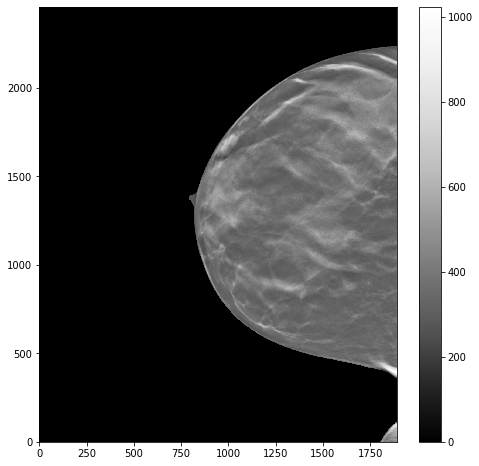

In [ ]:
plt.figure(figsize=(8,8))
plt.pcolormesh(img[20], cmap='Greys_r')
plt.colorbar()

In [ ]:
mask = img>200

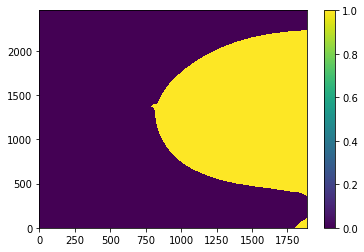

In [ ]:
plt.pcolormesh(mask[20])
plt.colorbar()

In [ ]:
mask.shape

(61, 2457, 1890)

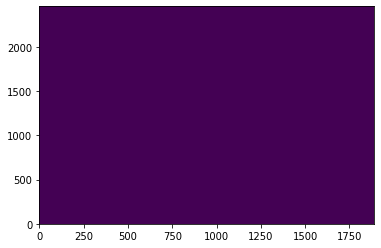

In [ ]:
#mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)
#plt.pcolormesh(mask[30])

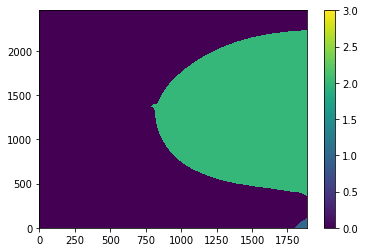

In [ ]:
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
plt.pcolormesh(mask_labeled[20])
plt.colorbar()

In [ ]:
slc = mask_labeled[20]


In [ ]:
rps = regionprops(slc)

In [ ]:
areas = [r.area for r in rps]
idxs = np.argsort(areas)[::-1] # we want largest to smallest

In [ ]:
areas

[5590, 1522331, 1]

In [ ]:
idxs

array([1, 0, 2])

In [ ]:
new_slc = np.zeros_like(slc)
for i in idxs[:2]:
    new_slc[tuple(rps[i].coords.T)] = i+1

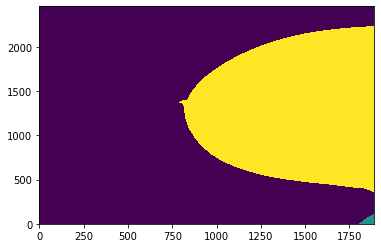

In [ ]:
plt.pcolormesh(new_slc)

In [ ]:
new_slc.min()

0

In [ ]:
def keep_top_2(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:2]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

In [ ]:
mask_labeled = np.vectorize(keep_top_2, signature='(n,m)->(n,m)')(mask_labeled)

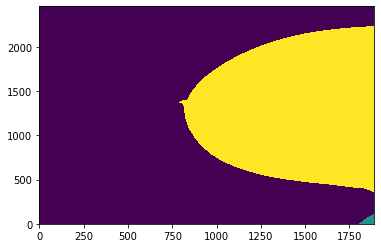

In [ ]:

plt.pcolormesh(mask_labeled[20])

In [ ]:
# fill in any small holes in the lungs:
mask = mask_labeled > 0
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)

In [ ]:
np.max(mask[0])

True

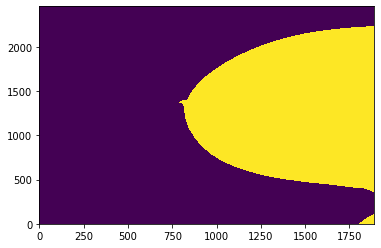

In [ ]:
plt.pcolormesh(mask[20])

In [ ]:
def delete_smalls(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc.shape[0]):
            new_slc[labels==idx] = 0
        elif (COM_y > 0.6*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

In [ ]:
mask_new = np.vectorize(delete_smalls, signature='(n,m)->(n,m)')(mask)

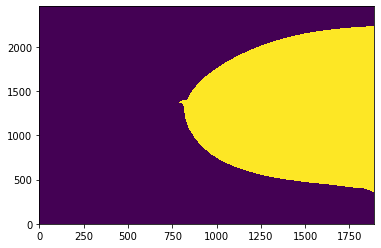

In [ ]:

plt.pcolormesh(mask_new[20])

In [ ]:
mask_new = binary_dilation(mask_new, iterations=5)

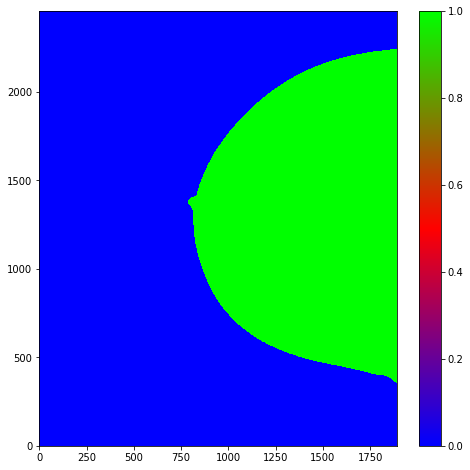

In [ ]:
plt.figure(figsize=(8,8))
plt.pcolormesh(mask_new[20], cmap='brg')
plt.colorbar()

In [ ]:
# Lets plot the full 3D image in plotly and create an interactive plot:


# 

In [ ]:
# First decrease the resolution a little bit:
im = zoom(1*(mask_new), (0.4,0.4,0.4))


In [ ]:
im.shape

(24, 983, 756)

In [ ]:
z, y, x = [np.arange(i) for i in im.shape]
#z*=4

In [ ]:
#create meshgrid
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

In [ ]:
z.shape

(24,)

In [ ]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.transpose(im,(1,2,0)).flatten(),
    isomin=0.1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=1, # needs to be a large number for good volume rendering
    ))
fig.write_html(folder+"test2.html")

In [ ]:
img_new = mask_new * img

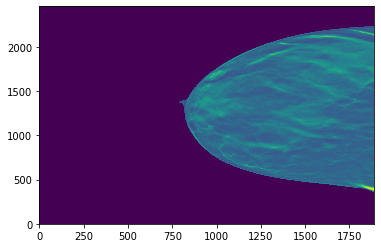

In [ ]:
plt.pcolormesh(img_new[20])